In [1]:
# !pip install datasets transformers evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 572.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [2]:
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import pandas as pd
import numpy as np
import evaluate
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
train = load_dataset('dair-ai/emotion', 'split', split='train')
valid = load_dataset('dair-ai/emotion', 'split', split='validation')
test = load_dataset('dair-ai/emotion', 'split', split='test')
print('size of train: {}, validation: {}, test: {}'.format(len(train), len(valid), len(test)))

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/dair-ai___emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


size of train: 16000, validation: 2000, test: 2000


<Axes: >

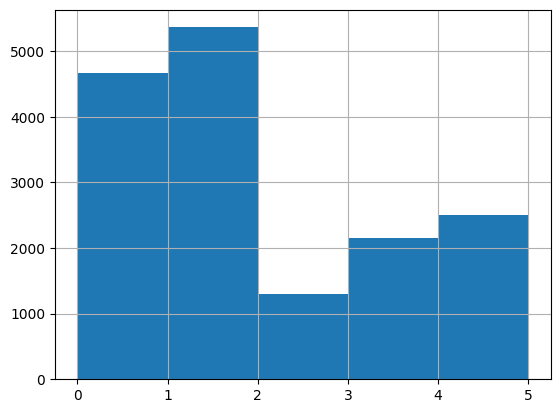

In [4]:
df = pd.DataFrame(train)
df['label'].hist(bins=5)

In [5]:
df['label'].value_counts()

1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: label, dtype: int64

In practice, uneven sample sizes could also happen.

# Preprocessing

In [6]:
train[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

For most of the case, 300 words are long enough to write a comment. Even if not, the main idea definitely appears in the first 300 words. As to text classification, it's ok to cut out some sentences, as long as the main points left.


In [8]:
type(train['text'])

list

In [9]:
def tokenizing(record):
    return tokenizer(record['text'], truncation=True, max_length=300)

train_tokenized = train.map(tokenizing)
valid_tokenized = valid.map(tokenizing)
test_tokenized = test.map(tokenizing)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [10]:
train_tokenized[0]

{'text': 'i didnt feel humiliated',
 'label': 0,
 'input_ids': [101, 1045, 2134, 2102, 2514, 26608, 102],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [11]:
id2label = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}
label2id = {v: k for k, v in id2label.items()}

# Define metrics

In [12]:
accuracy = evaluate.load('accuracy')
f1 = evaluate.load('f1')
precision = evaluate.load('precision')
recall = evaluate.load('recall')
def metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    ret = dict()
    ret.update(accuracy.compute(predictions=predictions, references=labels))
    ret.update(f1.compute(predictions=predictions, references=labels, average="macro"))
    ret.update(precision.compute(predictions=predictions, references=labels, average='macro'))
    ret.update(recall.compute(predictions=predictions, references=labels, average='macro'))
    return ret

# Load Pre-trained Model

In [13]:
bert = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=6,
    id2label=id2label,
    label2id=label2id
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [14]:
args = TrainingArguments(
    output_dir='./output',
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    weight_decay=0.2,
    logging_strategy='epoch',
    evaluation_strategy='epoch',
    save_strategy='epoch',
)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='pt')
trainer = Trainer(
    model=bert,
    args=args,
    data_collator=data_collator,
    train_dataset=train_tokenized,
    eval_dataset=valid_tokenized,
    compute_metrics=metrics
)

In [15]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.769400,0.251315,0.911500,0.883513,0.883941,0.885718
2,0.183400,0.155429,0.936500,0.912699,0.908390,0.918431
3,0.122200,0.149805,0.943500,0.922927,0.917500,0.929934
4,0.092400,0.145716,0.934000,0.908314,0.910186,0.908816
5,0.072600,0.185689,0.933500,0.908064,0.916194,0.902311
6,0.056200,0.179461,0.942500,0.919580,0.922321,0.919626
7,0.045400,0.194537,0.936500,0.914587,0.914123,0.915262
8,0.032900,0.210405,0.937500,0.916841,0.913302,0.921114
9,0.028600,0.218211,0.938500,0.918627,0.917695,0.919721
10,0.022600,0.220059,0.939000,0.918173,0.922552,0.914012


TrainOutput(global_step=2500, training_loss=0.14255217933654785, metrics={'train_runtime': 1527.035, 'train_samples_per_second': 104.778, 'train_steps_per_second': 1.637, 'total_flos': 4652628326691840.0, 'train_loss': 0.14255217933654785, 'epoch': 10.0})

In [35]:
classifer = BertForSequenceClassification.from_pretrained('./output/checkpoint-1000/')

In [36]:
pred = trainer.predict(test_tokenized)

In [37]:
pred

PredictionOutput(predictions=array([[ 7.415069 , -1.3755411, -1.5669466, -1.4573195, -2.0708508,
        -1.2401725],
       [ 7.6090546, -1.8958348, -1.5463958, -1.298182 , -1.6388379,
        -1.5864478],
       [ 7.631559 , -2.0975237, -1.489634 , -1.1169446, -1.8062979,
        -1.5880251],
       ...,
       [-1.6632502,  7.708198 , -1.6833587, -1.7136388, -1.82934  ,
        -1.1225997],
       [-1.4443277,  7.4600616, -2.1471586, -1.8428843, -1.228564 ,
        -1.1319574],
       [-1.6895972, -2.0491183, -1.4757581, -2.0228071,  4.521923 ,
         3.8851004]], dtype=float32), label_ids=array([0, 0, 0, ..., 1, 1, 4]), metrics={'test_loss': 0.2642507553100586, 'test_accuracy': 0.916, 'test_f1': 0.8677882224192602, 'test_precision': 0.8696573803303854, 'test_recall': 0.8662530900194892, 'test_runtime': 5.7698, 'test_samples_per_second': 346.631, 'test_steps_per_second': 5.546})

In [38]:
print(test_tokenized[1000])
print(pred.predictions[1000], pred.label_ids[1000])


{'text': 'i grew up around this feeling living only minutes away from the gorgeous atlantic ocean in brazil so its probably no surprise i grew fond of the ocean', 'label': 1, 'input_ids': [101, 1045, 3473, 2039, 2105, 2023, 3110, 2542, 2069, 2781, 2185, 2013, 1996, 9882, 4448, 4153, 1999, 4380, 2061, 2049, 2763, 2053, 4474, 1045, 3473, 13545, 1997, 1996, 4153, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
[-2.2180374   7.351618   -0.01186537 -1.9014986  -2.7453012  -1.0453573 ] 1


In [39]:
param_size = 0
for param in bert.parameters():
    param_size += param.nelement() 

print('trainable parameters: {:e}'.format(param_size))

trainable parameters: 1.094869e+08
